# 第一個資料集
https://universe.roboflow.com/supi-cd65u/motorcycle-license-plate-yfoi2/browse?queryText=&pageSize=50&startingIndex=50&browseQuery=true


In [ ]:
# 1. 安裝套件
!pip install ultralytics easyocr roboflow

# 2. 下載 Roboflow 資料集 (請替換為您的 API KEY)
from roboflow import Roboflow
rf = Roboflow(api_key="your_api_key")
project = rf.workspace("supi-cd65u").project("motorcycle-license-plate-yfoi2")
dataset = project.version(14).download("yolov8")

# 3. 訓練 YOLOv8 模型
from ultralytics import YOLO
model = YOLO('yolov8n.pt') # 使用輕量化的 nano 模型
results = model.train(data=f"{dataset.location}/data.yaml", epochs=50, imgsz=512, batch=16, amp=True, patience=20)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 136.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 28.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-hea


Extracting Dataset Version Zip to motorcycle-license-plate-14 in yolov8:: 100%|██████████| 6149/6149 [00:01<00:00, 4502.31it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/motorcycle-license-plate-14/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False


0: 512x384 1 license-plates, 2 motorcycles, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
OCR candidates: ['AERAV087', 'AER']
最終車牌: AER1087


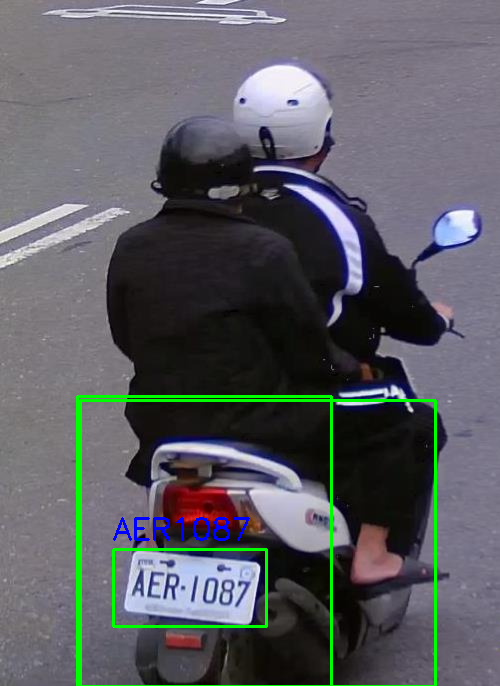

In [ ]:
import cv2
import easyocr
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import re

# ===== 初始化 =====
reader = easyocr.Reader(['en'], gpu=True)
model = YOLO('/content/runs/detect/train/weights/best.pt')

# ===== OCR 清理 =====
def clean_plate_text(text):
    text = text.upper()
    text = text.replace('|', '1').replace('I', '1').replace('L', '1')
    text = text.replace('O', '0')
    return re.sub(r'[^A-Z0-9]', '', text)

# ===== 只在「數字區」修正 AV =====
def fix_digit_region(text):
    """
    僅當 AV 出現在「應該是數字」的位置時，才修正為 1
    """
    m = re.match(r'^([A-Z0-9]{1,3})(.+)$', text)
    if m:
        prefix, tail = m.groups()
        tail = tail.replace('AV', '1').replace('VA', '1')
        return prefix + tail
    return text

# ===== 台灣車牌七規則 =====
def extract_valid_plate(candidates):
    patterns = [
        r'^[A-Z]{3}[0-9]{4}$',      # AAA1234
        r'^[0-9]{4}[A-Z]{2}$',      # 1234AA
        r'^[A-Z][0-9][0-9]{4}$',    # A1xxxx -> 1個英文+1個數字+4數字
        r'^[0-9]{4}[A-Z][0-9]$',    # 1234A5
        r'^[0-9][A-Z][0-9]{4}$',    # 1Axxxx -> 1個數字+1個英文+4數字
        r'^[0-9]{4}[0-9][A-Z]$',    # 12345A -> 4個數字+1個數字+1個英文
        r'^[0-9]{3}[A-Z]{3}$',    # 123AAA -> 3個數字+3個英文
    ]

    fixed_candidates = []
    for text in candidates:
        t = clean_plate_text(text)
        t = fix_digit_region(t)
        fixed_candidates.append(t)

    for t in fixed_candidates:
        for p in patterns:
            if re.match(p, t):
                return t

    return None

# ===== 主流程 =====
def process_image(img_path):
    img = cv2.imread(img_path)
    results = model(img)

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = model.names[int(box.cls[0])]

            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

            if label == 'license-plates':
                plate = img[y1:y2, x1:x2]
                h, w = plate.shape[:2]
                plate = cv2.resize(plate, (w*3, h*3), interpolation=cv2.INTER_CUBIC)

                gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
                bin_img = cv2.adaptiveThreshold(
                    gray, 255,
                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                    cv2.THRESH_BINARY, 15, 3
                )

                res_gray = reader.readtext(
                    gray,
                    allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
                )
                res_bin = reader.readtext(
                    bin_img,
                    allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
                )

                all_results = res_gray + res_bin
                all_results.sort(key=lambda x: x[0][0][0])

                ocr_texts = [r[1] for r in all_results]
                print("OCR candidates:", ocr_texts)

                plate_text = extract_valid_plate(ocr_texts)

                if plate_text:
                    print("最終車牌:", plate_text)
                    cv2.putText(
                        img, plate_text,
                        (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1.0, (255,0,0), 2
                    )

    cv2_imshow(img)

# ===== 測試 =====
process_image('testpicture.jpg')


In [ ]:
import cv2
import easyocr
from ultralytics import YOLO
import re
import numpy as np

# ===== 初始化 =====
reader = easyocr.Reader(['en'], gpu=True)
model = YOLO('/content/runs/detect/train/weights/best.pt')

# ===== OCR 清理 =====
def clean_plate_text(text):
    text = text.upper()
    text = text.replace('|', '1').replace('I', '1').replace('L', '1')
    text = text.replace('O', '0')
    return re.sub(r'[^A-Z0-9]', '', text)

# ===== 只在數字區修正 AV / VA =====
def fix_av_in_digit_region(text):
    """
    僅在「應該是數字的區段」才把 AV / VA 視為 1
    """
    # 英文字開頭的情況
    m = re.match(r'^([A-Z]{1,3})(.+)$', text)
    if m:
        prefix, tail = m.groups()
        tail = tail.replace('AV', '1').replace('VA', '1')
        return prefix + tail

    return text

# ===== 車牌規則判斷（台灣七規則）=====
def extract_valid_plate(candidates):
    patterns = [
        r'^[A-Z]{3}[0-9]{4}$',      # AAA1234
        r'^[0-9]{4}[A-Z]{2}$',      # 1234AA
        r'^[A-Z][0-9][0-9]{4}$',    # A1XXXX
        r'^[0-9]{4}[A-Z][0-9]$',    # 1234A5
        r'^[0-9][A-Z][0-9]{4}$',    # 1AXXXX
        r'^[0-9]{4}[0-9][A-Z]$',    # 12345A
        r'^[0-9]{3}[A-Z]{3}$',    # 123ABC
    ]

    cleaned = []
    for text in candidates:
        t = clean_plate_text(text)
        t = fix_av_in_digit_region(t)
        cleaned.append(t)

    # 依七規則驗證
    for t in cleaned:
        for p in patterns:
            if re.match(p, t):
                return t

    return None

# ===== 影片處理 =====
def process_video(video_path, output_path='finalvideo.mp4'):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        timestamp = frame_idx / fps

        results = model(frame, verbose=False)

        for r in results:
            for box in r.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                label = model.names[int(box.cls[0])]

                # ===== 機車 =====
                if label == 'motorcycle':
                    cv2.rectangle(frame, (x1,y1), (x2,y2), (255,0,0), 2)
                    cv2.putText(frame, label, (x1, y1-10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)

                # ===== 車牌 =====
                elif label == 'license-plates':
                    cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)

                    pad = 5
                    plate = frame[max(0,y1-pad):y2+pad,
                                  max(0,x1-pad):x2+pad]

                    # 放大
                    plate = cv2.resize(
                        plate, None, fx=2.5, fy=2.5,
                        interpolation=cv2.INTER_CUBIC
                    )

                    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
                    gray = cv2.medianBlur(gray, 3)
                    gray = cv2.equalizeHist(gray)

                    bin_img = cv2.adaptiveThreshold(
                        gray, 255,
                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                        cv2.THRESH_BINARY, 15, 3
                    )

                    # OCR 灰階 + 二值化
                    res_gray = reader.readtext(
                        gray,
                        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
                    )
                    res_bin = reader.readtext(
                        bin_img,
                        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
                    )

                    all_results = res_gray + res_bin
                    all_results.sort(key=lambda x: x[0][0][0])

                    ocr_texts = [r[1] for r in all_results]
                    plate_text = extract_valid_plate(ocr_texts)
                    display_text = "license-plates"

                    if plate_text:
                        display_text = f"plate: {plate_text}"
                        print(f"[{timestamp:.2f}s] 車牌: {plate_text}")

                    cv2.putText(frame, display_text, (x1, y1-10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)

        out.write(frame)

    cap.release()
    out.release()
    print("✅ 處理完成，影片輸出：", output_path)

# ===== 執行 =====
process_video('myselftest.mp4')

[4.77s] 車牌: 6039JC
[4.80s] 車牌: 1039JC
[4.80s] 車牌: 6039JC
[4.83s] 車牌: 6039JC
[4.87s] 車牌: 6039JC
[4.90s] 車牌: 6039JC
[4.90s] 車牌: 6039JC
[4.97s] 車牌: 6039JC
[4.97s] 車牌: 6039JC
[5.17s] 車牌: 6039JC
[9.53s] 車牌: AAT9106
[9.70s] 車牌: AAT9106
[9.73s] 車牌: AAT9106
[9.77s] 車牌: AAT9106
[13.90s] 車牌: 6533C8
[33.83s] 車牌: BSA7311
[33.90s] 車牌: BSA7311
[34.20s] 車牌: BSA7311
[34.23s] 車牌: BSA7311
[34.27s] 車牌: BSA7311
[34.30s] 車牌: BSA7311
[34.53s] 車牌: BSA7511
[34.57s] 車牌: BSA7311
[35.10s] 車牌: BSA7311
[35.10s] 車牌: BSA7311
[35.13s] 車牌: BSA7311
[35.13s] 車牌: BSA7311
[35.50s] 車牌: BSA7311
[35.60s] 車牌: BSA7314
[35.60s] 車牌: BSA7317
[35.60s] 車牌: BSA7377
[35.70s] 車牌: BSA7311
[39.17s] 車牌: E88223
[39.20s] 車牌: E88223
[39.23s] 車牌: E88223
[39.27s] 車牌: E88223
[39.30s] 車牌: E88223
[39.33s] 車牌: E88223
[39.37s] 車牌: E88223
[39.40s] 車牌: E88223
[39.43s] 車牌: E88223
[39.47s] 車牌: E88223
[39.53s] 車牌: E88223
[39.57s] 車牌: E88223
[39.60s] 車牌: E88223
[39.63s] 車牌: E88223
[39.67s] 車牌: E88223
[99.73s] 車牌: B98401
[99.87s] 車牌: 991PDV
[100.17s] 車牌:

# 第二個資料集: #
https://universe.roboflow.com/jackresearch0/taiwan-license-plate-recognition-research-tlprr/dataset/7

In [ ]:
# 安裝 YOLOv8 與 OCR 必要的套件
!pip install ultralytics easyocr roboflow -q

from roboflow import Roboflow
from ultralytics import YOLO
import cv2
import easyocr
from google.colab.patches import cv2_imshow
import pandas as pd

# 下載台灣車牌專用資料集 (Version 7)
rf = Roboflow(api_key="your_api_key")
project = rf.workspace("jackresearch0").project("taiwan-license-plate-recognition-research-tlprr")
dataset = project.version(7).download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 26.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings r


Extracting Dataset Version Zip to taiwan-license-plate-recognition-research-tlprr-7 in yolov8:: 100%|██████████| 38988/38988 [00:04<00:00, 8446.73it/s] 


In [ ]:
# 初始化並開始訓練
model = YOLO('yolov8n.pt')
model.train(data=f"{dataset.location}/data.yaml", epochs=50, imgsz=512, batch=16, amp=True, patience=20)

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/taiwan-license-plate-recognition-research-tlprr-7/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dc0ce375eb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete
0: 512x384 1 plate, 110.7ms
Speed: 2.7ms preprocess, 110.7ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 384)
🔍 OCR 原始輸出：
[([[np.float64(31.95500553103597), np.float64(24.042068584846014)], [np.float64(349.7459851511681), np.float64(64.44268450788665)], [np.float64(328.04499446896403), np.float64(173.95793141515398)], [np.float64(10.254014848831924), np.float64(132.55731549211333)]], 'AER1087', np.float64(0.7972176762984425))]
  - 文字: AER1087, conf=0.80, 清理後: AER1087
✅ 符合台灣規則的車牌：AER1087


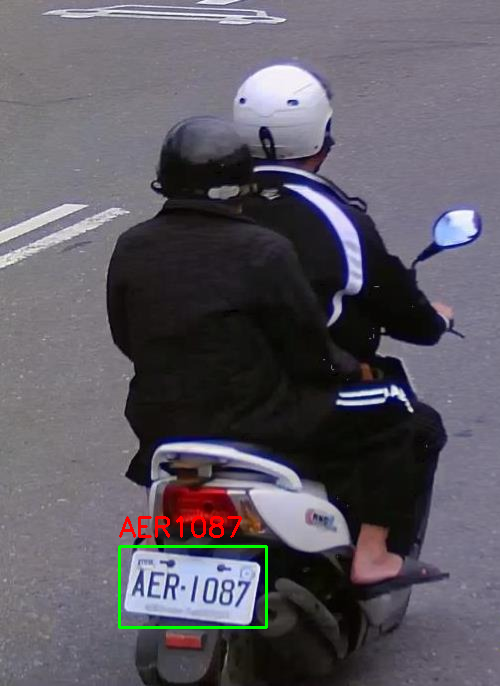

In [ ]:
import cv2
import easyocr
import re
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# ===== 車牌文字清理 =====
def clean_plate_text(text):
    text = text.upper()
    text = text.replace('|', '1').replace('I', '1').replace('L', '1')
    text = text.replace('O', '0')
    return re.sub(r'[^A-Z0-9]', '', text)

# ===== 台灣車牌規則判斷（七規則） =====
def extract_taiwan_plate(candidates):
    """
    從 OCR 結果中找出符合台灣車牌格式的字串（七規則）
    """
    patterns = [
        r'[A-Z]{3}[0-9]{4}',   # 3英 + 4數
        r'[0-9]{4}[A-Z]{2}',   # 4數 + 2英
        r'[A-Z][0-9]{5}',      # 1英 + 5數
        r'[0-9]{4}[A-Z][0-9]', # 4數 + 1英 + 1數
        r'[0-9][A-Z][0-9]{4}', # 1數 + 1英 + 4數
        r'[0-9]{4}[0-9][A-Z]',  # 4數 + 1數 + 1英
        r'[0-9]{3}[A-Z]{3}',  # 3數 + 3英
    ]

    matches = []
    for text in candidates:
        for p in patterns:
            found = re.findall(p, text)
            matches.extend(found)

    if matches:
        # 取最長（資訊最多）的
        return max(matches, key=len)

    return None

# ===== Debug 主程式 =====
def process_plate_debug(image_path):
    model = YOLO('/content/runs/detect/train/weights/best.pt')
    reader = easyocr.Reader(['en'], gpu=False)

    img = cv2.imread(image_path)
    results = model(img)

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            plate = img[y1:y2, x1:x2]
            plate = cv2.resize(plate, None, fx=2.5, fy=2.5, interpolation=cv2.INTER_CUBIC)

            gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
            gray = cv2.equalizeHist(gray)

            ocr_result = reader.readtext(
                gray,
                allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
            )

            print("🔍 OCR 原始輸出：")
            print(ocr_result)

            cleaned_texts = []

            for det in ocr_result:
                raw_text = det[1]
                conf = det[2]
                cleaned = clean_plate_text(raw_text)

                print(f"  - 文字: {raw_text}, conf={conf:.2f}, 清理後: {cleaned}")
                cleaned_texts.append(cleaned)

            # 🔥 套用台灣車牌七規則
            final_plate = extract_taiwan_plate(cleaned_texts)

            if final_plate:
                print(f"✅ 符合台灣規則的車牌：{final_plate}")
                display_text = final_plate
            else:
                print("❌ 沒有符合台灣車牌格式")
                display_text = ''.join(cleaned_texts)

            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(
                img, display_text,
                (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9, (0,0,255), 2
            )

    cv2_imshow(img)

# ===== 測試 =====
process_plate_debug('testpicture.jpg')


In [ ]:
import cv2
import easyocr
import pandas as pd
import re
from ultralytics import YOLO

# ===== 台灣車牌七規則 =====
def is_valid_taiwan_plate(plate):
    patterns = [
        r'^[A-Z]{3}[0-9]{4}$',       # AAA1234
        r'^[0-9]{4}[A-Z]{2}$',       # 1234AA
        r'^[A-Z][0-9][0-9]{4}$',     # A1XXXX -> 1英+1數+4數
        r'^[0-9]{4}[A-Z][0-9]$',     # 1234A5
        r'^[0-9][A-Z][0-9]{4}$',     # 1A1234 -> 1數+1英+4數
        r'^[0-9]{4}[0-9][A-Z]$',     # 12341A -> 4數+1數+1英
        r'^[0-9]{3}[A-Z]{3}$',     # 123AAA -> 3數+3英
    ]
    return any(re.match(p, plate) for p in patterns)

def process_taiwan_plate_video(
    video_path,
    output_path="output_with_bbox.mp4"
):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # 載入模型與 OCR
    best_model = YOLO('/content/runs/detect/train/weights/best.pt')
    reader = easyocr.Reader(['en'])

    # 建立影片輸出
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    records = []

    print(f"{'影片時間':<12} | {'車牌號碼'}")
    print("-" * 30)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_id = cap.get(cv2.CAP_PROP_POS_FRAMES)
        timestamp_seconds = frame_id / fps

        results = best_model(frame, verbose=False)

        for r in results:
            for box in r.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])

                # 畫 Bounding Box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # OCR ROI
                plate_roi = frame[y1:y2, x1:x2]

                # 灰階 + OTSU
                gray = cv2.cvtColor(plate_roi, cv2.COLOR_BGR2GRAY)
                _, plate_bin = cv2.threshold(
                    gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
                )

                ocr_data = reader.readtext(
                    plate_bin,
                    allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789',
                    detail=1
                )

                if not ocr_data:
                    continue

                raw_text = ocr_data[0][1]

                # 清理 OCR 結果
                plate_no = re.sub(r'[^A-Z0-9]', '', raw_text.upper())

                # 基本長度過濾
                if len(plate_no) < 5:
                    continue

                # ★ 台灣車牌七規則驗證
                if not is_valid_taiwan_plate(plate_no):
                    continue

                minutes = int(timestamp_seconds // 60)
                seconds = timestamp_seconds % 60
                time_str = f"{minutes:02d}:{seconds:05.2f}"

                print(f"{time_str:<12} | {plate_no}")
                records.append({
                    "time": time_str,
                    "plate": plate_no
                })

                # 標註車牌
                cv2.putText(
                    frame,
                    plate_no,
                    (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    (0, 0, 255),
                    2
                )

        out.write(frame)

    cap.release()
    out.release()

    print(f"\n✅ 已輸出影片：{output_path}")
    return pd.DataFrame(records)


# ===== 執行 =====
df_results = process_taiwan_plate_video(
    "myselftest.mp4",
    output_path="result_plate_detection_taiwan.mp4"
)

df_results


影片時間         | 車牌號碼
------------------------------
00:01.10     | C20605
00:01.23     | C05155
00:01.27     | C20605
00:01.33     | C20605
00:01.67     | C20605
00:01.70     | C20605
00:01.90     | C20605
00:01.97     | K20605
00:02.17     | C20605
00:02.23     | K20605
00:02.27     | C20545
00:02.30     | C20615
00:02.43     | C20805
00:02.50     | C20805
00:02.53     | C20805
00:02.67     | I20605
00:02.70     | C20605
00:02.90     | C20605
00:02.93     | C20605
00:02.93     | 6239JC
00:02.97     | I20651
00:03.13     | C20605
00:03.43     | C20605
00:03.47     | C20605
00:03.47     | 6039JC
00:03.60     | C20615
00:03.60     | 6039J0
00:03.63     | 6039JC
00:03.67     | C20605
00:03.67     | 6039JC
00:03.73     | 6039J0
00:03.77     | 6039J0
00:03.83     | 6039NC
00:03.90     | 6039JC
00:03.97     | 6039J0
00:04.13     | 6039JC
00:04.17     | 6039JC
00:04.23     | 6039JC
00:04.27     | 6039JC
00:04.53     | 6039JC
00:04.73     | 6039J0
00:04.77     | 6039JC
00:04.87     | 6039J0
00:

,time,plate
0,00:01.10,C20605
1,00:01.23,C05155
2,00:01.27,C20605
3,00:01.33,C20605
4,00:01.67,C20605
...,...,...
379,02:31.47,NNL3869
380,02:31.63,HKL3819
381,02:31.67,NNL3819
382,02:31.93,NNL3869
